# Given by the template 
https://colab.research.google.com/drive/1495rzqiMxfqwqBjaanDwDGN7eOS4oXRX 


**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [5]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
#   !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !git clone https://github.com/Barrel-Titor/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9265 (delta 4), reused 7 (delta 2), pack-reused 9256
Receiving objects: 100% (9265/9265), 129.48 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (9149/9149), done.


In [6]:
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_val_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = list(range(0, len(train_val_dataset), 2))   # split the indices for your train split
val_indexes = list(range(1, len(train_val_dataset), 2))     # split the indices for your val split

train_dataset = Subset(train_val_dataset, train_indexes)
val_dataset = Subset(train_val_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [9]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train and Validation**

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.001 |
| Decaying step size | 20 epochs |
| Decaying factor | 0.1 |
| Optimiser | SGD |
| Epochs | 30 |



In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [37]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.514472484588623
Step 10, Loss 4.51784086227417
Accuracy 0.09197786998616875

Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.451831817626953
Accuracy 0.09197786998616875

Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.3598456382751465
Accuracy 0.09197786998616875

Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.310239315032959
Accuracy 0.09197786998616875

Starting epoch 5/30, LR = [0.001]
Step 50, Loss 4.355845928192139
Accuracy 0.09301521438450899

Starting epoch 6/30, LR = [0.001]
Step 60, Loss 4.299665927886963
Accuracy 0.09612724757952974

Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.188819885253906
Accuracy 0.09439834024896265

Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.319115161895752
Accuracy 0.09647302904564316

Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.173344612121582
Accuracy 0.09716459197786999

Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.158774375915527
Accuracy 0.09336099585062241

Startin

In [0]:
import matplotlib.pyplot as plt

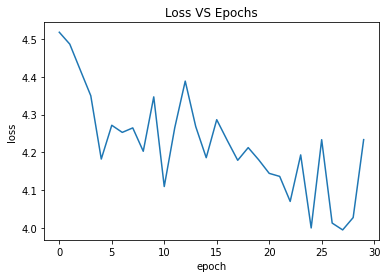

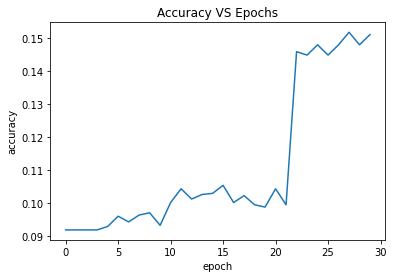

In [42]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Validation**

In [0]:
# net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
# net.train(False) # Set Network to evaluation mode

# running_corrects = 0
# for images, labels in tqdm(val_dataloader):
#   images = images.to(DEVICE)
#   labels = labels.to(DEVICE)

#   # Forward Pass
#   outputs = net(images)

#   # Get predictions
#   _, preds = torch.max(outputs.data, 1)

#   # Update Corrects
#   running_corrects += torch.sum(preds == labels.data).data.item()

# # Calculate Accuracy
# accuracy = running_corrects / float(len(val_dataset))

# print('Validation Accuracy: {}'.format(accuracy))

**Test**

In [40]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Test Accuracy: 0.15485655029381265


# Experiment with different sets of hyperparameters